In [20]:
import geopandas as gpd
from pyproj import CRS
import pandas as pd
import matplotlib.pyplot as plt

In [21]:


cities = gpd.read_file(gpd.datasets.get_path("naturalearth_cities"))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
print(cities.head())

objects = pd.read_csv('./startup-investments/objects.csv')
pd.set_option('display.max_columns', None)
objects.head()

           name                   geometry
0  Vatican City  POINT (12.45339 41.90328)
1    San Marino  POINT (12.44177 43.93610)
2         Vaduz   POINT (9.51667 47.13372)
3    Luxembourg   POINT (6.13000 49.61166)
4       Palikir  POINT (158.14997 6.91664)


C:\Users\Benedikt\AppData\Local\Temp\ipykernel_20464\181193522.py:5: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects = pd.read_csv('./startup-investments/objects.csv')


,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,closed_at,domain,homepage_url,twitter_username,logo_url,logo_width,logo_height,short_description,description,overview,tag_list,country_code,state_code,city,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,http://wetpaint-inc.com,BachelrWetpaint,http://s3.amazonaws.com/crunchbase_prod_assets...,401,54,NaN,Technology Platform Company,Wetpaint is a technology platform company that...,"wiki, seattle, elowitz, media-industry, media-...",USA,WA,Seattle,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,NaN,flektor.com,http://www.flektor.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,186,85,NaN,NaN,Flektor is a rich-media mash-up platform that ...,"flektor, photo, video",USA,CA,Culver City,Los Angeles,NaN,NaN,0,0,NaN,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,NaN,there.com,http://www.there.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,107,34,NaN,NaN,There.com is an online virtual world where any...,"virtualworld, there, teens",USA,CA,San Mateo,SF Bay,NaN,NaN,0,0,NaN,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,NaN,mywebbo.com,http://www.mywebbo.com,NaN,NaN,0,0,NaN,NaN,"BRAND NEW ONLINE SOCIAL NETWORKING WEBSITE,FOR...","social-network, new, website, web, friends, ch...",NaN,NaN,NaN,unknown,NaN,NaN,0,0,NaN,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,NaN,themoviestreamer.com,http://themoviestreamer.com,NaN,http://s3.amazonaws.com/crunchbase_prod_assets...,200,74,NaN,NaN,This company shows free movies online on their...,"watch, full-length, moives, online, for, free,...",NaN,NaN,NaN,unknown,NaN,NaN,0,0,NaN,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18


## Selecting important infomation from whole set

In [22]:
df_objects = objects[['id','entity_type','category_code','country_code', 'state_code', 'city']]

# only select Companies (get rid of people or other entities)
df_companies = df_objects.loc[df_objects['entity_type'] == 'Company']
df_companies = df_companies.drop('entity_type', axis=1)

df_companies = df_companies.dropna()
print("Got " + str(df_companies.shape[0]) + " datapoints")
df_companies.head(20)

Got 45823 datapoints


,id,category_code,country_code,state_code,city
0,c:1,web,USA,WA,Seattle
1,c:10,games_video,USA,CA,Culver City
2,c:100,games_video,USA,CA,San Mateo
8,c:10005,advertising,USA,NY,New York
12,c:10009,advertising,USA,NM,Santa Fe
13,c:1001,web,USA,CA,Mountain View
15,c:10011,games_video,USA,CA,Julian
18,c:10014,mobile,USA,CA,Palo Alto
19,c:10015,health,USA,CA,San Francisco
20,c:100155,cleantech,USA,TX,Austin


## Merge Map and Datapoints on city Name

In [23]:
cities.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


In [26]:
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [35]:
# cities = cities.rename(columns={"name":"city"})
# map_and_stats = cities.merge(df_companies, on="city")
# print(map_and_stats.shape[0])
# print(cities.shape[0])
# print(df_companies.shape[0])
# map_and_stats.head()

df_companies = df_companies.rename(columns={"country_code":"iso_a3"})
map_and_stats = countries.merge(df_companies, on="iso_a3")

print(map_and_stats.shape[0])
print(cities.shape[0])
print(df_companies.shape[0])
map_and_stats.head()

45807
202
45823


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,id,category_code,state_code,city
0,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",c:12739,advertising,OH,Markham
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",c:139817,software,OH,Toronto
2,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",c:142089,web,OH,Waterloo
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",c:21339,software,AL,"Calgary, Alberta"
4,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",c:214933,software,OH,Toronto


## Plot Data

In [54]:
map_and_stats["category_code"].unique()

#TODO Kategorisieren -> das sind zu viele auf dem Plot
#TODO pro land evtl nur die mehrheit anzeigen? Oder Land aufsplitten in Farben????
#TODO einzelne Plot für Länder erstellen?

array(['advertising', 'software', 'web', 'hospitality', 'biotech',
       'other', 'design', 'mobile', 'public_relations', 'ecommerce',
       'games_video', 'health', 'cleantech', 'analytics', 'consulting',
       'finance', 'medical', 'manufacturing', 'enterprise',
       'network_hosting', 'hardware', 'government', 'security',
       'photo_video', 'travel', 'semiconductor', 'search', 'social',
       'transportation', 'education', 'nonprofit', 'news', 'sports',
       'fashion', 'messaging', 'music', 'legal', 'automotive',
       'real_estate', 'nanotech', 'pets', 'local'], dtype=object)

C:\Users\Benedikt\AppData\Local\Temp\ipykernel_20464\384649552.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


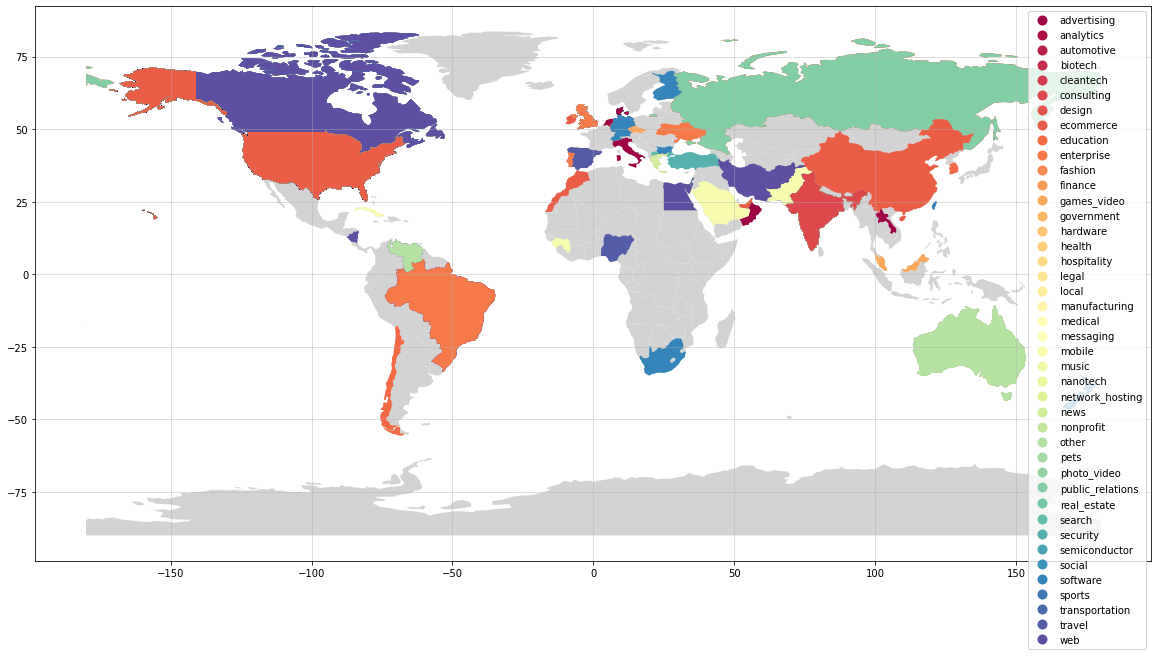

In [52]:
# initialize an axis
fig, ax = plt.subplots(figsize=(20,16))

# plot map on axis




countries.plot(color="lightgrey",ax=ax)# parse dates for plot's title

map_and_stats.plot(column="category_code",
                categorical=True,
                cmap='Spectral',
                legend=True,

                ax=ax)
# add grid
ax.grid(b=True, alpha=0.5)
plt.show()